In [1]:
import os
from matrix_client.api import MatrixHttpApi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matrixstats import *

In [4]:
with open(".matrix_token") as f:
    token = str(f.read()).strip()

homeserver = "https://matrix.cadair.com"
stop_time = None

api = MatrixHttpApi(homeserver, token=token)

In [5]:
ids = {'astropy': get_rooms_in_community(api, "+astropy:openastronomy.org"),
       'sunpy': get_rooms_in_community(api, "+sunpy:openastronomy.org")}

In [8]:
events, messages = load_messages(api, ids, refresh_cache=True, stop_time=stop_time, ignore_github=True,
                                ignore_rooms=['astropy_irc_and_gitter'])

fetching events for astropy_general
fetching events for astropy_irc_and_gitter
fetching events for astropy_random
fetching events for astropy_astroquery
fetching events for astropy_coordinates
fetching events for astropy_ci_issues
fetching events for astropy_spectroscopy
fetching events for astropy_fits
fetching events for astropy_gsoc
fetching events for astropy_learn
fetching events for astropy_affiliated_general
fetching events for astropy_meeting2018_logistics
fetching events for astropy_jobs
fetching events for astropy_leaveslack
fetching events for astropy_table
fetching events for astropy_units
fetching events for astropy_pkg_infrastructure
fetching events for astropy_meeting2018_social
fetching events for astropy_releasing
fetching events for astropy_modeling
fetching events for astropy_wcs
fetching events for astropy_ihateconda
fetching events for astropy_meeting2019
fetching events for astropy_pyvo
fetching events for astropy_workshops
fetching events for astropy_visualizatio

/home/stuart/.virtualenvs/matrix/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'sunpy_1.0_paper'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/stuart/.virtualenvs/matrix/lib/python3.8/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/stuart/.virtualenvs/matrix/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [9]:
# We ignore emtpy rooms
non_empty_messages = {group: {room: m for room, m in gmessages.items() if not m.empty}
                      for group, gmessages in messages.items()}
all_messages = {group: pd.concat(gmessages).reset_index(level=0)
                for group, gmessages in non_empty_messages.items()}

# Instant Messaging

All public channels in astropy.slack.org is bridged to chat.openastronomy.org

Matrix keeps all history which can requested from any matrix server in the room.

https://view.matrix.org/alias/%23astropy_general:openastronomy.org

Therefore... STATISTICS!

https://github.com/cadair/chat_stats

# Number of Channels

In [10]:
for group, df in messages.items():
    print(group, len(df))

astropy 61
sunpy 6


# Number of Messages per Channel

In [11]:
def get_len_key(adict, reverse=True):
    n_messages = {}
    for k in sorted(adict, key=lambda k: len(adict[k]), reverse=reverse):
        m = adict[k]
        n_messages[k] = len(m)
    return n_messages

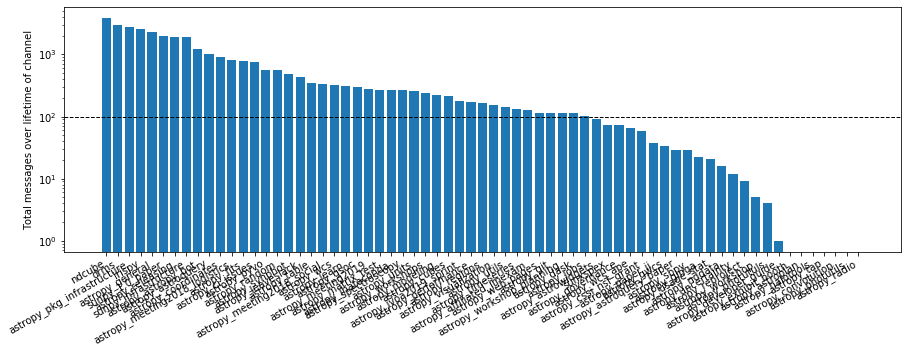

In [12]:
fig = plt.figure(figsize=(15,5))
n_messages = get_len_key(flatten_dicts(messages))
plt.bar(list(range(len(n_messages))), list(n_messages.values()), tick_label=list(n_messages.keys()))
fig.autofmt_xdate()
plt.axhline(100, linestyle="--", linewidth=1, color="k")
plt.semilogy()
_ = plt.ylabel("Total messages over lifetime of channel")

In [13]:
print_sorted_len(flatten_dicts(messages))

ndcube: 3828
drms: 2931
astropy_pkg_infrastructure: 2723
irispy: 2586
astropy_general: 2263
sunpy_1.0_paper: 1990
astropy_releasing: 1881
sunpy_infrastructure: 1875
astropy_astropy_bot: 1203
astropy_astroquery: 1024
astropy_coordinates: 896
astropy_meeting2018_logistics: 798
astropy_fits: 783
astropy_ci_issues: 762
astropy_pyvo: 569
astropy_random: 561
astropy_synphot: 491
astropy_leaveslack: 432
astropy_table: 340
astropy_meeting2018_social: 331
astropy_wcs: 326
astropy_learn: 307
astropy_gsoc: 297
astropy_meeting2019: 276
astropy_matrix_test: 272
astropy_ihateconda: 271
astropy_spectroscopy: 264
astropy_units: 253
astropy_workshops: 241
astropy_modeling: 219
astropy_cubes: 211
astropy_ivoa2019_sprint: 180
astropy_performance: 172
astropy_regions: 162
astropy_visualization: 154
astropy_utils: 143
astropy_timeseries: 130
astropy_affiliated_imexam: 127
astropy_web_pages: 116
astropy_git: 115
astropy_workshop_planning: 112
astropy_dask: 112
astropy_jobs: 102
astropy_astrowidgets: 91
sunx

In [14]:
channel_creation = {k:v.index[-1] for k, v in flatten_dicts(events).items()}

print_sorted_value(channel_creation, reverse=False)

drms: 2017-05-08 15:43:39.456000
astropy_pkg_infrastructure: 2018-02-22 11:49:41.385000
sunpy_infrastructure: 2018-04-23 13:33:35.460000
astropy_astropy_bot: 2018-04-23 19:16:39.906000
astropy_astroquery: 2018-04-23 19:17:28.238000
astropy_astroquery_paper: 2018-04-23 19:18:43.243000
astropy_coordinates: 2018-04-23 19:21:18.240000
astropy_cssi_nsf_grant: 2018-04-23 19:22:08.239000
astropy_fits: 2018-04-23 19:22:58.238000
astropy_git: 2018-04-23 19:24:28.232000
astropy_gsoc: 2018-04-23 19:25:13.238000
astropy_halotools: 2018-04-23 19:26:03.241000
astropy_jobs: 2018-04-23 19:27:33.243000
astropy_learn: 2018-04-23 19:28:23.232000
astropy_matrix_test: 2018-04-23 19:29:13.245000
astropy_paper_ii: 2018-04-23 19:29:58.235000
astropy_performance: 2018-04-23 19:30:43.245000
astropy_regions: 2018-04-23 19:33:13.240000
astropy_releasing: 2018-04-23 19:33:58.237000
astropy_spectroscopy: 2018-04-23 19:34:48.246000
astropy_table: 2018-04-23 19:35:33.236000
astropy_units: 2018-04-23 19:36:23.240000
a

In [15]:
messages_per_day = {group: pd.DataFrame({k:m['body'].resample("1D").count() for k,m in gm.items() if not m.empty})
                    for group, gm in messages.items()}

In [16]:
messages_per_week = {group: pd.DataFrame({k:m['body'].resample("1W").count() for k,m in gm.items() if not m.empty})
                     for group, gm in messages.items()}

In [17]:
total_mpd = {group: df.sum(axis=1) for group, df in messages_per_day.items()}
total_mpw = {group: df.sum(axis=1) for group, df in messages_per_week.items()}

## Total Messages per Week

/home/stuart/.virtualenvs/matrix/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


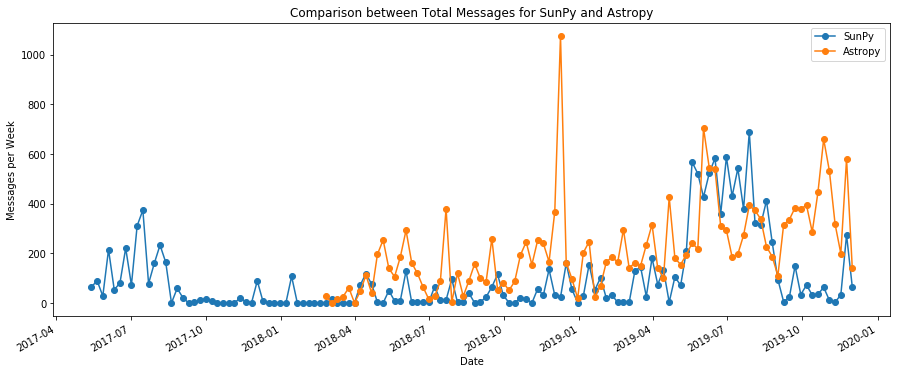

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total_mpw['sunpy'].index, total_mpw['sunpy'], "-o", label="SunPy")
ax.plot(total_mpw['astropy'].index, total_mpw['astropy'], "-o", label="Astropy")
fig.autofmt_xdate()
plt.legend()
ax.set_ylabel("Messages per Week")
ax.set_xlabel("Date")
ax.set_title("Comparison between Total Messages for SunPy and Astropy")
None

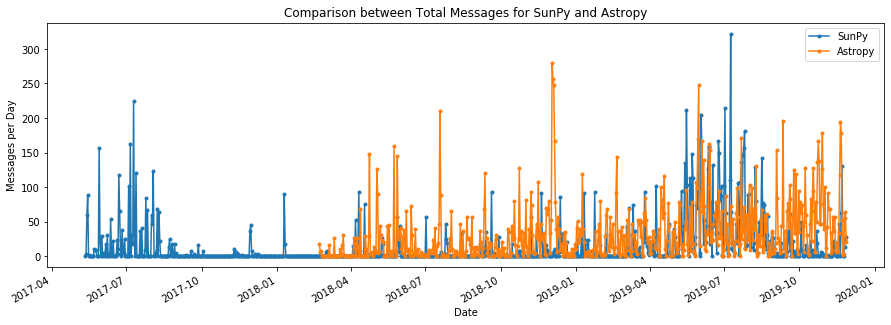

In [19]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Comparison between Total Messages for SunPy and Astropy")

ax.plot(total_mpd['sunpy'].index, total_mpd['sunpy'], "-o", ms=3, label="SunPy")
ax.plot(total_mpd['astropy'].index, total_mpd['astropy'], "-o", ms=3, label="Astropy")

fig.autofmt_xdate()
plt.legend()

ax.set_ylabel("Messages per Day")
ax.set_xlabel("Date")
#ax.axis((736596.85, 737035.15, 0.0, 500))
None

## Most Active Senders

In [20]:
active_senders = calculate_active_senders(api, all_messages, 20, "@slack_astropy_{s}:openastronomy.org")

In [21]:
# TODO: workout how to deduplicate users based on mxid
usender_map = {'@Cadair:matrix.org': '@cadair:cadair.com'}

In [22]:
active_senders['astropy'].iloc[:, 1:]

,number_of_messages,mean_body_len,median_body_len
display_name,,,
bsipocz,3792,148.368143,99.0
pllim,3490,112.523782,81.0
Cadair*,2398,62.104496,45.0
astrofrog,2323,84.482135,58.0
adamginsburg,913,91.071194,60.0
eteq,656,158.570122,112.5
saimn,354,132.661017,104.5
adrn,336,122.979167,72.0
kelle,307,172.706840,108.0


In [23]:
active_senders['sunpy'].iloc[:, 1:]

,number_of_messages,mean_body_len,median_body_len
display_name,,,
Cadair*,3114,49.974030,37.0
hitman23*,1379,152.461316,65.0
krisastern*,1218,82.300246,41.0
Nabobalis*,1194,35.472362,28.0
DanRyan37*,1168,72.883305,55.0
Kolja*,978,111.464213,67.0
nitinkgp23*,902,59.039387,36.0
Cadair*,663,48.424060,40.0
mbobra*,517,93.918762,62.0


In [24]:
all_senders = {}
for group, gmessages in all_messages.items():
    senders = pd.DataFrame(gmessages.groupby("usender").count()['body'].sort_values(ascending=False))
    all_senders[group] = senders

In [25]:
matrix = len(np.nonzero([":" in s for s in all_senders['astropy'].index])[0])

In [26]:
slack = len(np.nonzero([":" not in s for s in all_senders['astropy'].index])[0])

In [27]:
print("% of senders from matrix: ", (matrix / (slack+matrix))*100)

% of senders from matrix:  16.74418604651163


# Senders per Week

In [28]:
senders_per_day = {group: am.resample("1D").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}
senders_per_week = {group: am.resample("1W").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}

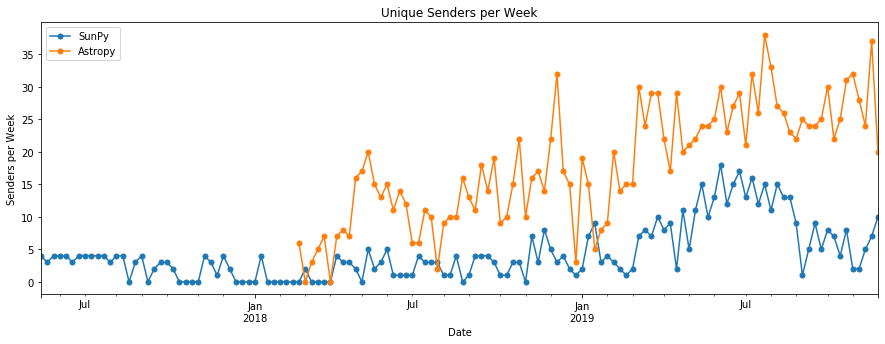

In [29]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Unique Senders per Week")
senders_per_week['sunpy'].plot(ax=ax, label="SunPy", style="o-", ms=5)
senders_per_week['astropy'].plot(ax=ax, label="Astropy", style="o-", ms=5)
ax.set_ylabel("Senders per Week")
ax.set_xlabel("Date")
#plt.xlim((2490, 2555))
_ = plt.legend()

## Messages per Day vs Senders per Day

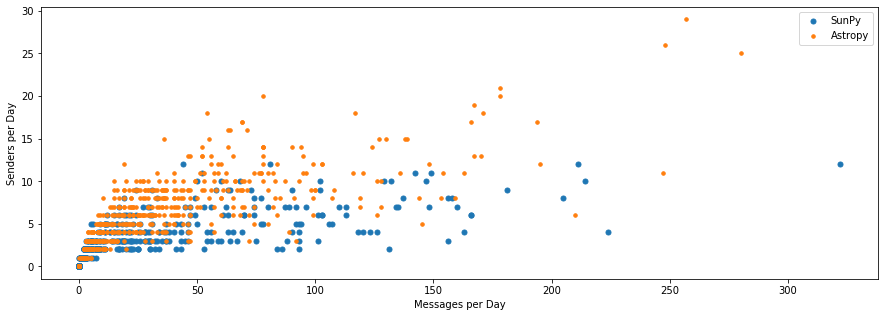

In [30]:
plt.figure(figsize=(15,5))
sp = plt.plot(total_mpd['sunpy'], senders_per_day['sunpy'], ".", color="C0", ms=10)
ap = plt.plot(total_mpd['astropy'].reindex(senders_per_day['astropy'].index),
              senders_per_day['astropy'], ".", color="C1", ms=7)
plt.xlabel("Messages per Day")
plt.ylabel("Senders per Day")
plt.legend((sp[0], ap[0]), ("SunPy", "Astropy"))